In [1]:
import sys
sys.path.append('..')

import json
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from src.plot_settings import set_publication_style
from src.models import DigitAdditionModel
from src.data_handler import MNISTAdditionDataset

# Set plot style for publication quality
set_publication_style()

# Set random seed to ensure reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

## Load the best model and evaluate on the validation and test set

In [2]:
# Load the best hyperparameters
with open('results/optimization_results.json', 'r') as f:
    saved_results = json.load(f)
    best_params = saved_results['best_hyperparameters']

best_params = {
    'units_per_layer': [best_params[f'units_l{i}'] for i in range(best_params['n_layers'])],
    'dropout_rate': best_params['dropout_rate'],
    'learning_rate': best_params['learning_rate'],
    'l2_reg': best_params['l2_reg'],
    'activation': best_params['activation']
}
# Build the model with the best hyperparameters
model = DigitAdditionModel()
model.build(best_params)

# Load the best model weights
model.load_weights('models/best_model_weights.weights.h5')

# # Save the complete model
# model.model.save('models/best_model.keras')

# Or load the .keras file using load_model: direct_model = load_model('models/best_model.keras')

/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
# Get the dataset
dataset = MNISTAdditionDataset(seed=seed)
data = dataset.create_datasets()

train_ds = dataset.get_tf_dataset(data['train'][0], data['train'][1])
val_ds = dataset.get_tf_dataset(data['val'][0], data['val'][1])
test_ds = dataset.get_tf_dataset(data['test'][0], data['test'][1], shuffle=False)

In [4]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation accuracy: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")

# Check if the results match the previous results during search
# I got the same results: 0.9634 for validation and 0.9484 for test


Validation accuracy: 0.9634

Test accuracy: 0.9484


In [5]:
model.model.summary()
plot_model(model.model, show_shapes=True, show_layer_names=True, to_file='../report/images/best_nn_architecture.pdf')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 56)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 567)            │       889,623 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 567)            │         2,268 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 567)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 215)            │       122,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 215)            │           860 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 215)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 208)            │        44,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 208)            │           832 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 208)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 823)            │       172,007 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 823)            │         3,292 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 823)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 19)             │        15,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251,586 (4.77 MB)

 Trainable params: 1,247,960 (4.76 MB)

 Non-trainable params: 3,626 (14.16 KB)

## t-SNE visulization

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


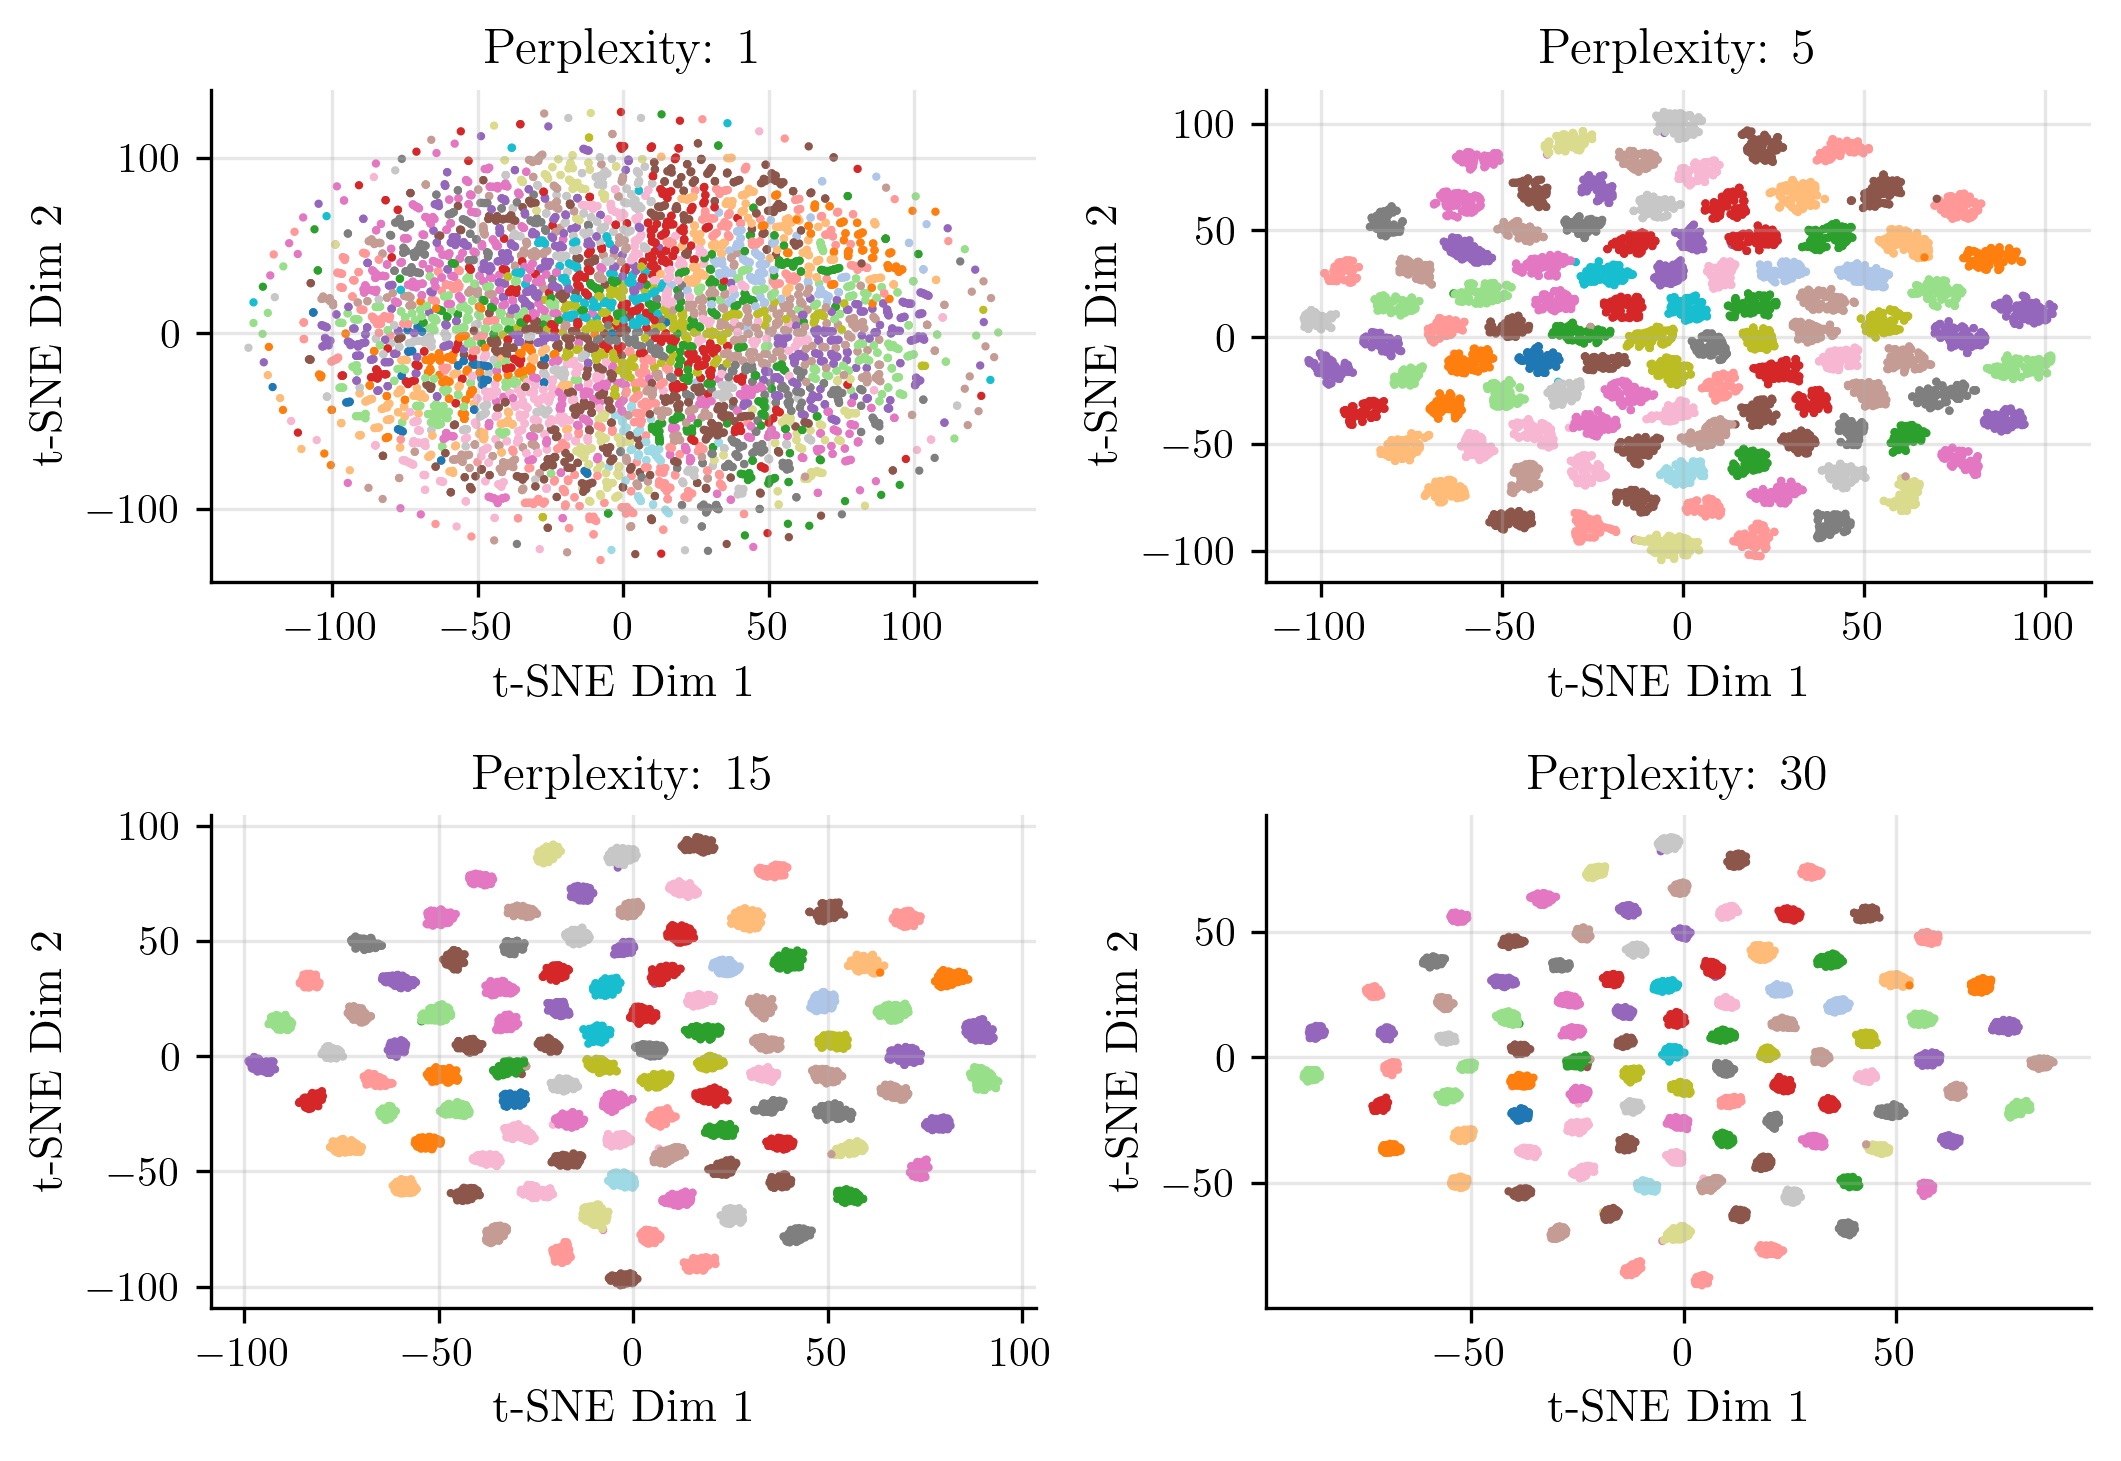

In [6]:
# Get the second last layer and build a new model with it as the output
second_last_layer = model.model.layers[-2]
model_second_last = tf.keras.models.Model(inputs=model.model.input, outputs=second_last_layer.output)

# Get the train set
train_inputs, train_outputs = data['train'][0][:10000], data['train'][1][:10000]

# Get the embeddings of the train set
train_embeddings = model_second_last.predict(train_inputs)

# Define perplexity values
perplexities = [1, 5, 15, 30]

# Initialize figure
fig, axes = plt.subplots(2, len(perplexities)//2)
axes = axes.ravel() # Flatten the axes array to make it iterable

# Apply t-SNE for each perplexity and plot
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_embedded = tsne.fit_transform(train_embeddings)  # Use a subset for efficiency
    scatter = axes[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c=train_outputs.astype(int), cmap='tab20', s=1)
    axes[i].set_title(f"Perplexity: {perplexity}")
    axes[i].set_xlabel("t-SNE Dim 1")
    axes[i].set_ylabel("t-SNE Dim 2")

plt.tight_layout()
plt.savefig('../report/images/embeddings_tsne.pdf', bbox_inches='tight', dpi=300)
plt.show()

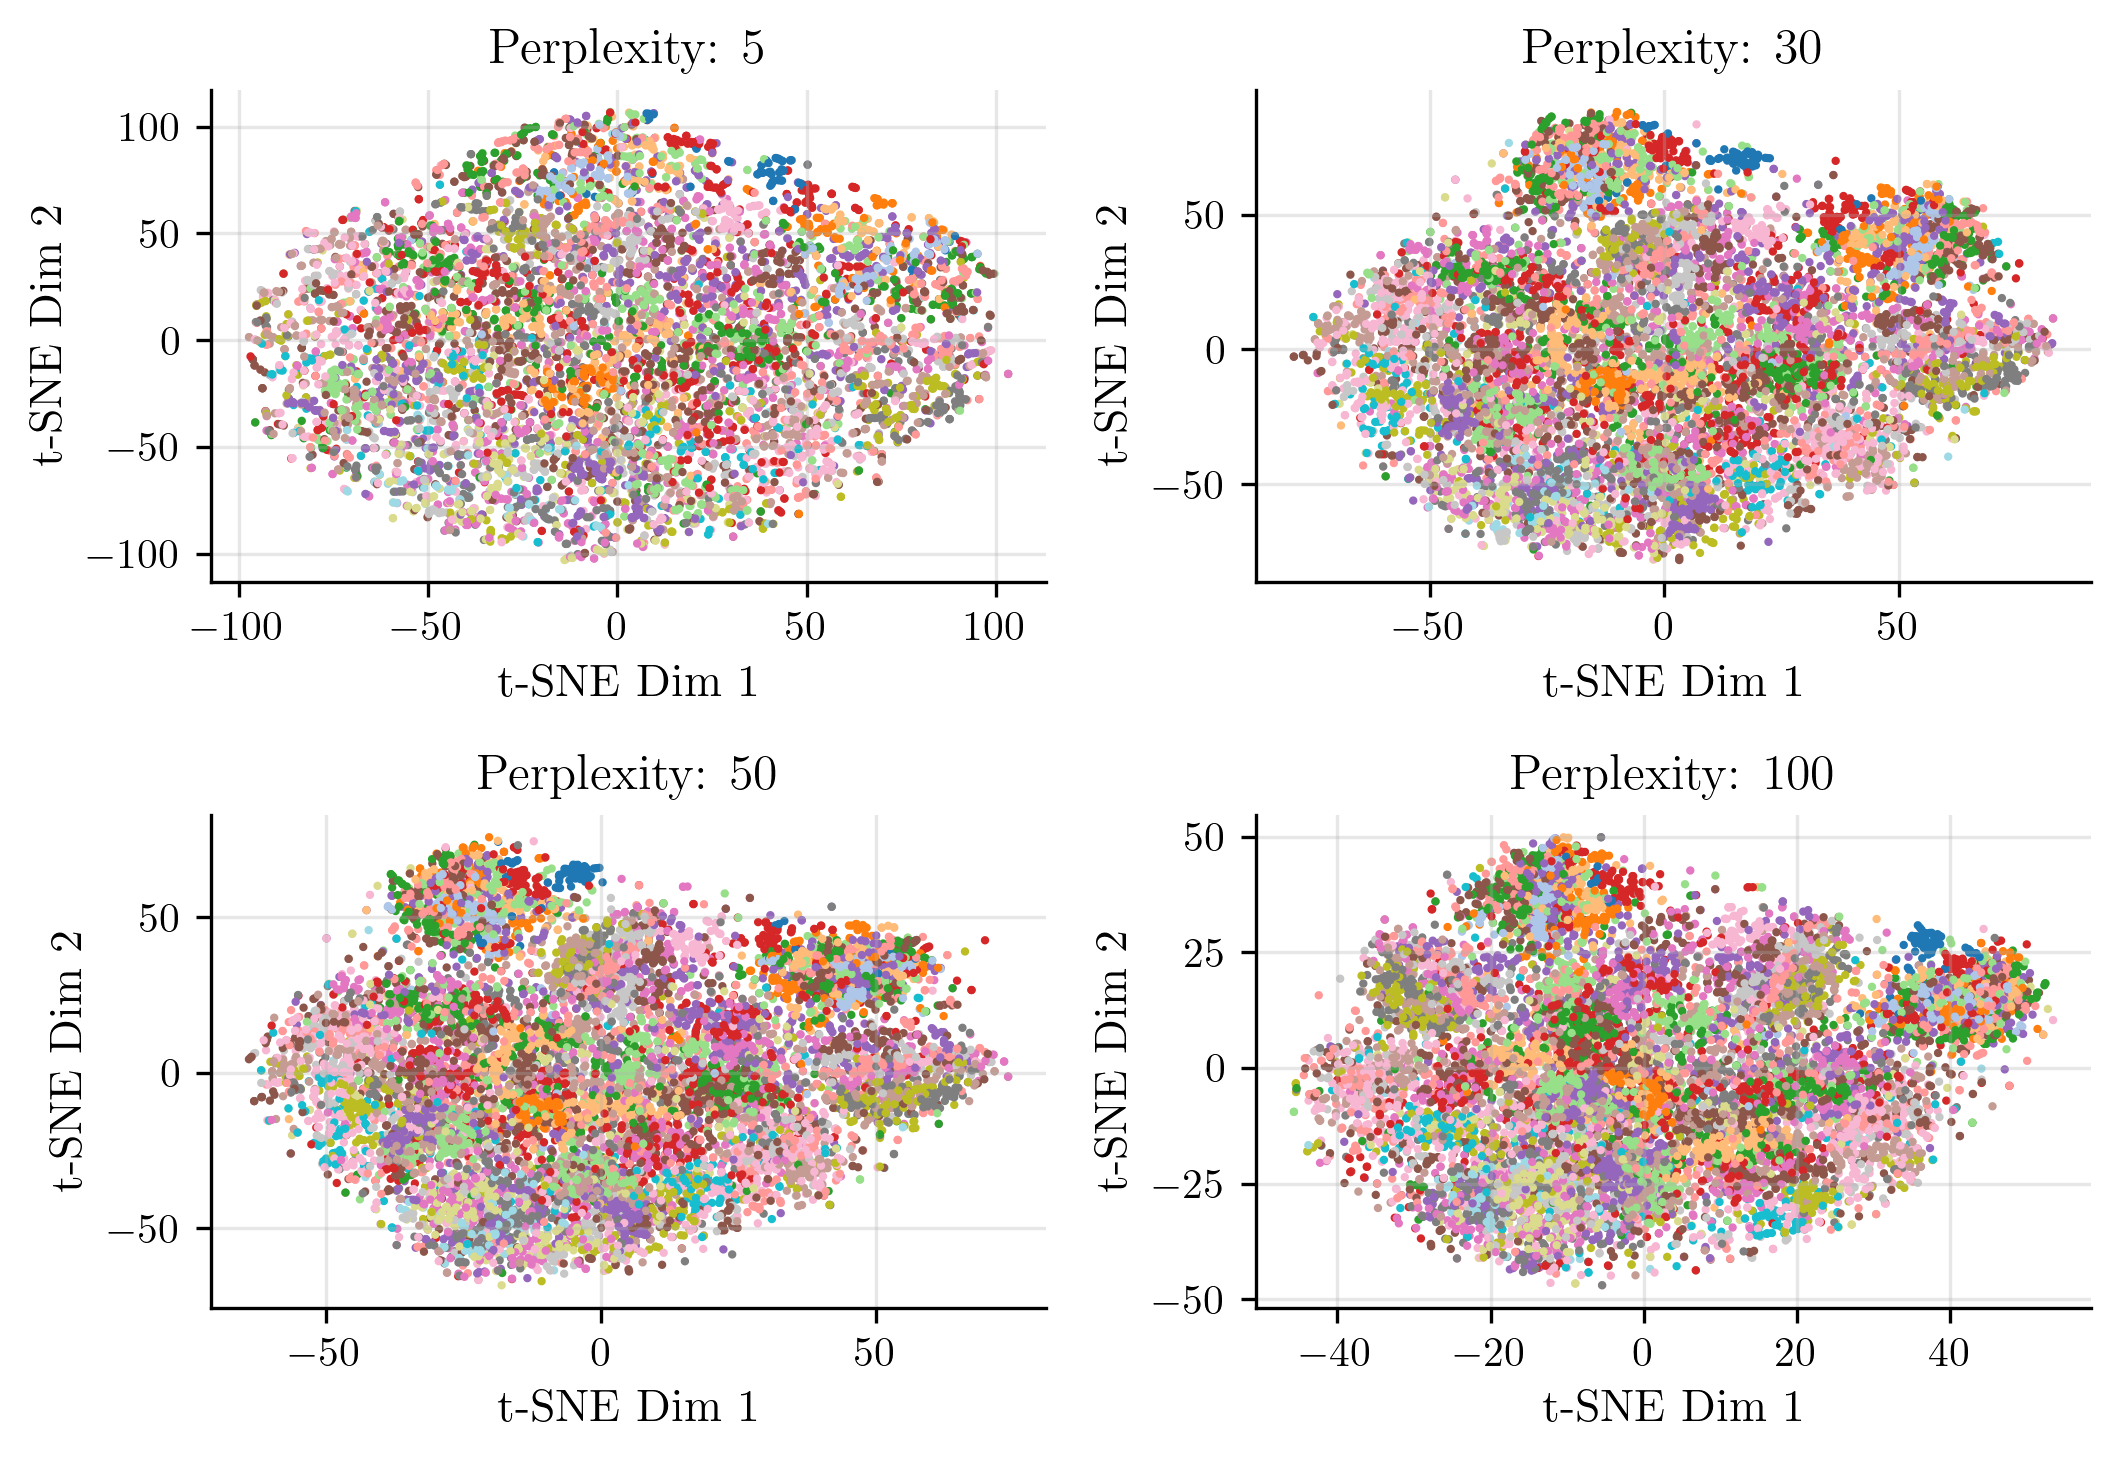

In [7]:
# Directly apply the t-SNE on the inputs

train_inputs_reshaped = train_inputs.reshape(train_inputs.shape[0], -1)  # -1 automatically calculates 28 * 56 = 1568

# Define perplexity values
perplexities = [5, 30, 50, 100]

# Initialize figure
fig, axes = plt.subplots(2, len(perplexities)//2)
axes = axes.ravel() # Flatten the axes array to make it iterable

# Apply t-SNE for each perplexity and plot
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_embedded = tsne.fit_transform(train_inputs_reshaped)  # Use a subset for efficiency
    scatter = axes[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c=train_outputs.astype(int), cmap='tab20', s=1)
    axes[i].set_title(f"Perplexity: {perplexity}")
    axes[i].set_xlabel("t-SNE Dim 1")
    axes[i].set_ylabel("t-SNE Dim 2")

plt.tight_layout()
plt.savefig('../report/images/inputs_tsne.pdf', bbox_inches='tight', dpi=300)
plt.show()